<a href="https://colab.research.google.com/github/aurimas13/CodeAcademy-AI-Course/blob/main/Notebooks_Finished/Computer_Vision_7_L2_Demonstration_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Importing libraries**

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

# Import helpers
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Train model on GPU otherwise on CPU
device = ('cuda' if torch.cuda.is_available() else 'cpu')

# **Define, Download and Normalize**


In [2]:
# Define transform to normalize data
transform = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.1307,), (0.3081,))
                                 ])
 
 # Download an load the training MNIST data
train_set = datasets.MNIST('DATA_MNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.MNIST('DATA_MNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting DATA_MNIST/MNIST/raw/train-images-idx3-ubyte.gz to DATA_MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting DATA_MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to DATA_MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting DATA_MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to DATA_MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting DATA_MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to DATA_MNIST/MNIST/raw



In [3]:
training_data = enumerate(trainloader)
batch_idx, (images, labels) = next(training_data)
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


# **Plotting images as pictures**

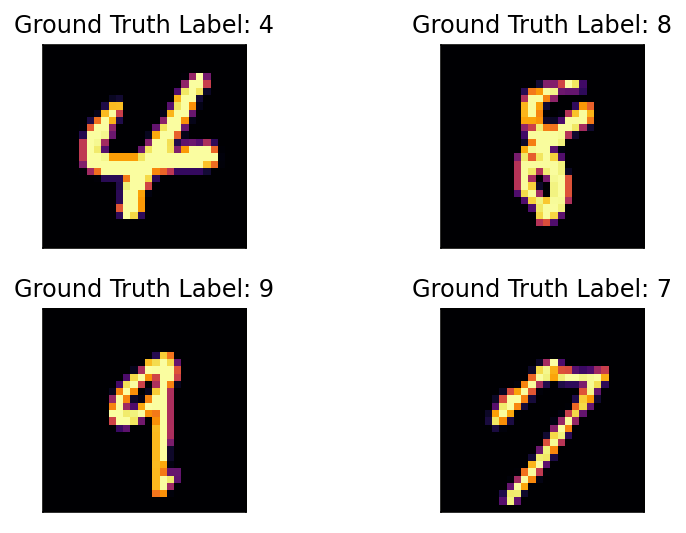

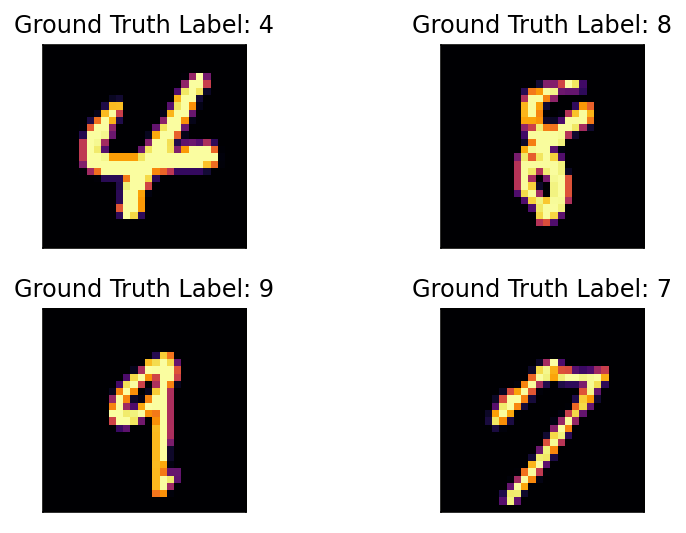

In [4]:
fig = plt.figure()
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.tight_layout()
  plt.imshow(images[i][0], cmap='inferno')
  plt.title('Ground Truth Label: {}'.format(labels[i]))
  plt.yticks([])
  plt.xticks([])
fig

# **Neural Network Architecture**

In [12]:
class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    # Convolutional Neural Network layer
    self.convolutional_neural_network_layers = nn.Sequential(
        # We caclute the output of each covoluion layer using the formula:
        # outputOfEachConvLayer = [(in_channel + 2*padding - kernel_size) / stride] + 1
        nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=1, stride=1),  # (N, 1, 28, 28)
        nn.ReLU(),
        # After the first convolutional layer the output of this layer is:
        # [(28 + 2*1 - 3) /1] + 1 = 28
        nn.MaxPool2d(kernel_size=2),
        # Since we applied maxxpooling with kernel_size =2 we have to divide by 2 and we get:
        # 28 / 2 = 14
        # Output of our second convultion layer
        nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        # After the second convolutional layer output of our second convultion layer the output of this layer will be:
        # [(14 + 2*1 - 3/1)] + 1  = 14
        nn.MaxPool2d(kernel_size=2)
        # Since we applined maxpooling with kernel_size=2 we have divide by 2 and we get then:
        # 14 / 2 = 7
    )

    # Linear Layer
    self.linear_layers = nn.Sequential(
        # We have the output channels of 24 of our second convolutional and 7*7 from formula
        # which give us the output of each convolutional layer
        nn.Linear(in_features=24*7*7, out_features=64),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(in_features=64, out_features=10)
    )

  # Defining forward pass
  def forward(self, x):
    x = self.convolutional_neural_network_layers(x)
    # After we get output of our convolutional layer we must flatten it 
    x = x.view(x.size(0), -1)
    # Then pass it through the linear layer
    x = self.linear_layers(x)
    # The softmax function returns the prob likelihood of getting the input image.
    # We will see a graphical demonstration below
    x = F.log_softmax(x, dim=1)
    return x

In [13]:
model = Network()
model.to(device)
print(model)

Network(
  (convolutional_neural_network_layers): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1176, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [14]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [17]:
epochs = 10 # The total number of iteration

train_losses = []
test_losses = []

for epoch in range(epochs):
  # model for training
  model.train()
  train_loss = 0

  for idx, (images, labels) in enumerate(trainloader):

    # Send these >>> To GPU
    images = images.to(device)
    labels = labels.to(device)

    # Training pass
    optimizer.zero_grad()

    # Forward pass
    output = model(images)
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  else:
    # model for evaluation
    model.eval()
    test_loss = 0
    accuracy = 0

    # Turn off gradients when performing evaluation.
    # As if we don't turn it off, we  will comprise our networks weight entirely
    with torch.no_grad():
      for images, labels in testloader:

        images = images.to(device)
        labels = labels.to(device) 

        log_probabilities = model(images)
        test_loss += criterion(log_probabilities, labels).item()

        probabilites = torch.exp(log_probabilities)
        top_prob, top_class = probabilites.topk(1, dim=1)
        predictions = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(predictions.type(torch.FloatTensor))

      train_losses.append(train_loss/len(trainloader))
      test_losses.append(test_loss/len(trainloader))

      print("Epoch: {}/{}   ".format(epoch+1, epochs),
            "Training loss: {:.4f}   ".format(train_loss/len(trainloader)),
            "Testing loss: {:.4f}   ".format(test_loss/len(trainloader)),
            "Test accuracy: {:.4f}   ".format(accuracy/len(testloader)))

Epoch: 1/10    Training loss: 0.2578    Testing loss: 0.0249    Test accuracy: 0.9572   
Epoch: 2/10    Training loss: 0.1799    Testing loss: 0.0197    Test accuracy: 0.9647   
Epoch: 3/10    Training loss: 0.1383    Testing loss: 0.0145    Test accuracy: 0.9725   
Epoch: 4/10    Training loss: 0.1165    Testing loss: 0.0135    Test accuracy: 0.9749   
Epoch: 5/10    Training loss: 0.1010    Testing loss: 0.0105    Test accuracy: 0.9809   
Epoch: 6/10    Training loss: 0.0917    Testing loss: 0.0099    Test accuracy: 0.9801   
Epoch: 7/10    Training loss: 0.0827    Testing loss: 0.0091    Test accuracy: 0.9828   
Epoch: 8/10    Training loss: 0.0757    Testing loss: 0.0089    Test accuracy: 0.9819   
Epoch: 9/10    Training loss: 0.0705    Testing loss: 0.0078    Test accuracy: 0.9850   
Epoch: 10/10    Training loss: 0.0663    Testing loss: 0.0073    Test accuracy: 0.9860   


# **Plotting**

<class 'list'> <class 'list'>


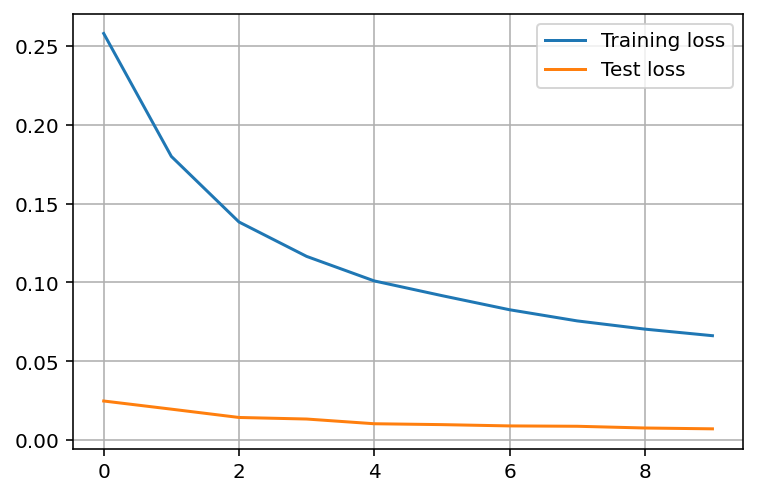

In [20]:
print(type(train_losses), type(test_losses))
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Test loss")
plt.legend()
plt.grid()

# **Showing Predictions**

In [22]:
img = images[0]
img = img.to(device)
img = img.view(-1, 1, 28, 28)
print(img.shape)

# Sice we want to use already pretrained wieghts to make some predicition
# we are turing of gradients
with torch.no_grad():
  logits = model.forward(img)

torch.Size([1, 1, 28, 28])


[9.9997962e-01 2.0516397e-07 9.5589985e-06 1.6008849e-08 2.3068162e-06
 8.0462215e-10 5.5108658e-06 2.5081288e-06 1.4883481e-07 3.0863652e-07]


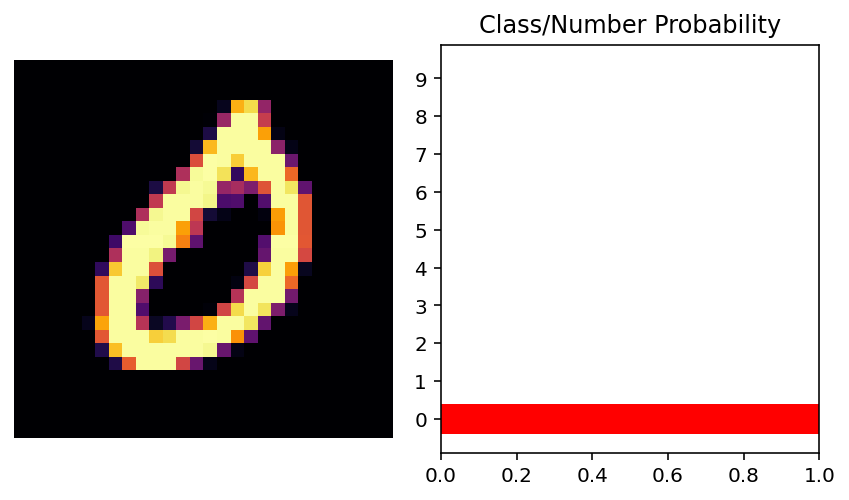

In [28]:
# We will tak softmax for probabilities
probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()

print(probabilities)

fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)
ax1.imshow(img.view(1, 28, 28).detach().cpu().numpy().squeeze(), cmap='inferno')
ax1.axis('off')
ax2.barh(np.arange(10), probabilities, color='r' )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_xlim(0, 1)
ax2.set_title('Class/Number Probability')

plt.tight_layout()

# **END OF DEMONSTRATION ON MNIST DATA WITH CNN**